In [1]:
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
import copy
import random
import scipy as scipy
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import svm
from sklearn import linear_model
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from joblib import parallel_backend
from sklearn import impute
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn import inspection
import joblib
import scipy.stats as stats
import datetime
import time
from joblib import load
from sklearn.neural_network import MLPClassifier
import inspect
import xgboost as xgb
import lightgbm as lgb
import importlib
import os
import shap

from sklearn import feature_selection

import sys
sys.path.append('/mnt/shared_folders/eResearch_glaucoma_project/andrewholmes2024')
import model_functions
importlib.reload(model_functions)

import data_functions
importlib.reload(data_functions)

from sklearn import cluster
from sklearn import decomposition

import umap

In [3]:
ocular_features = [
    'IOPcc_mean_tx_adjusted', 'corneal_hysteresis_mean', 'corneal_resistance_factor_mean', 'SE_mean', 'self_reported_myopia',
    'RNFL_thickness_mean', 'RNFL_intereye_difference', 'GCIPL_thickness_mean', 'GCIPL_intereye_difference', 'macular_thickness_mean',
    'IOPcc_highest_intereye_difference', 'corneal_hysteresis_lowest_intereye_difference',

    'logMAR_mean',
]

In [4]:
demographic_features = [
    'age_at_assesement','is_male', 
    'white_ethnicity', 'asian_ethnicity', 'black_ethnicity', 'chinese_ethnicity', 'other_ethnicity', 'missing_ethnicity',
    'Standardized_PRS_Craig2020', 'APOE4_carrier', 
    'PM25', 'townsend_deprivation_index', 'is_urban',
]

In [5]:
systemic_features = [
    'falls_in_last_year_ordinal',
    'diagnosed_hypertension', 'diagnosed_hypotension', 'diagnosed_dyslipidemia', 'diagnosed_raynaud_syndrome', 'diagnosed_migraine',
    'diagnosed_diabetes_mellitus', 'diagnosed_sleep_apnoea', 'diagnosed_chronic_kidney_disease', 'diagnosed_hypothyroidism',
    'diagnosed_thyrotoxicosis', 'diagnosed_h_pylori', 'diagnosed_autoimmune', 'diagnosed_COPD', 'diagnosed_asthma', 'diagnosed_rosacea',
    'diagnosed_atopic_dermatitis', 'diagnosed_rhinosinusitis', 'diagnosed_gout', 'poor_oral_health_def_2', 'diagnosed_depression_or_anxiety', 
    'on_metformin', 'on_statin', 'on_beta_blocker_systemic', 'on_CCB', 'on_SSRI', 'on_SNRI', 'on_ACE_inhibitor', 'on_ARB', 'on_diuretic',

    'BMI', 'waist_hip_ratio', 'systolic_BP', 'diastolic_BP', 'HBA1c_mmol',
    'triglycerides', 'total_cholesterol', 'HDL_cholesterol', 'LDL_cholesterol', 
    'apolipoprotein_A', 'apolipoprotein_B',
    'eGFR_cystatin_c', 'microalbumin_creatinine_ratio', 'urate', 'total_bilirubin', 'albumin', 'CRP',
    'platelet_to_lymphocyte_ratio', 'neutrophil_to_lymphocyte_ratio', 'lymphocyte_to_monocyte_ratio',

    'glucose_mmolL', 'blood_vitamin_D',
]

In [6]:
lifestyle_features = [
    'walking_mins_weekly', 'moderate_activity_mins_weekly', 'vigorous_activity_mins_weekly',
    'sleep_duration_normal', 'insomnia_usually', 'daytime_sleeping', 'snoring',
    'current_cigarettes_daily', 'past_cigarettes_daily', 'alcohol_intake_frequency',
    'caffeinated_coffee_drinker', 'tea_cups_per_day',
    'all_vegetables_tbsp_per_day', 'all_fruit_tbsp_per_day', 'salt_added_to_food', 'oily_fish_intake',
]

In [7]:
features_ensemble1_OD = ocular_features + demographic_features
features_ensemble2_ODS = ocular_features + demographic_features + systemic_features
features_ensemble3_ODSL = ocular_features + demographic_features + systemic_features + lifestyle_features

features_ensemble_4_DSL = demographic_features + systemic_features + lifestyle_features

print(len(features_ensemble1_OD))
print(len(features_ensemble2_ODS))
print(len(features_ensemble3_ODSL))
print(len(features_ensemble_4_DSL))

26
78
94
81


In [8]:
ocular_df = pd.read_pickle('/mnt/shared_folders/eResearch_glaucoma_project/andrewholmes2024/ocular/data/ocular_df.pkl')
demographic_df = pd.read_pickle('/mnt/shared_folders/eResearch_glaucoma_project/andrewholmes2024/demographic/data/demographic_df.pkl')
systemic_df = pd.read_pickle('/mnt/shared_folders/eResearch_glaucoma_project/andrewholmes2024/systemic_models/data/systemic_df.pkl')
lifestyle_df = pd.read_pickle('/mnt/shared_folders/eResearch_glaucoma_project/andrewholmes2024/lifestyle/data/lifestyle_df.pkl')

In [9]:
# Remove black ethnicity from systemic df (overlap with demographic)
systemic_df = systemic_df.drop(columns=['black_ethnicity'])

In [10]:
combo_df = pd.merge(ocular_df, demographic_df, on='f.eid', how='outer')
combo_df = pd.merge(combo_df, systemic_df, on='f.eid', how='outer')
combo_df = pd.merge(combo_df, lifestyle_df, on='f.eid', how='outer')

In [11]:
combo_df = data_functions.merge_case_and_diagnosis_cols(combo_df, 'UPD_glaucoma_final_def_limitedexclusions.pkl')

In [12]:
OCT_subcohort_df = combo_df[combo_df['OCT_subcohort'] == 1]

In [13]:
def min_max_scaler_with_inverter(X_train, X_test):
    scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler


In [14]:
X_train, y_train, X_test, y_test = model_functions.get_train_test_datasets(
    OCT_subcohort_df, 
    'train_test_split_OCT_stratified_glaucoma_final_def_limitedexclusions_stratified', 
    'Binary_All_glaucoma_final_def_limitedexclusions', 
    features_ensemble3_ODSL
)


X_train_no_scale, X_test_no_scale = model_functions.impute_using_median(X_train, X_test)
X_train, X_test, scaler_obj = min_max_scaler_with_inverter(X_train_no_scale, X_test_no_scale)
reconstructed_df = pd.DataFrame(X_train, columns=features_ensemble3_ODSL)

In [15]:
reconstructed_df_with_def_no_scale = pd.DataFrame(X_train_no_scale.reset_index(), columns=features_ensemble3_ODSL)
reconstructed_df_with_def_no_scale['y'] = y_train.values

In [16]:
xgb_odsl_octsub = load(
    '/mnt/shared_folders/eResearch_glaucoma_project/andrewholmes2024/5Jul2024_stable_outputs/main_results/OCT_sub_cohort/multi_XGBClassifier_2024-07-04_07_24/features_ensemble3_ODSL_multi_XGBClassifier_oct_only_df_Binary_All_glaucoma_final_def_limitedexclusions_impute_using_median_min_max_scaler_2024-07-04_07_42.pkl'
).best_estimator_

# 2-cluster analysis on glaucoma only

In [18]:
glaucoma_idx_true = np.where(reconstructed_df_with_def_no_scale['y'] == 1)

In [28]:
umap_reducer = umap.UMAP()

In [20]:
# UMAP reduction

umap_reducer = umap.UMAP()
umapped = umap_reducer.fit_transform(explanation[glaucoma_idx_true].values)

In [22]:
# DBscan

est_hdbscan = cluster.HDBSCAN(n_jobs=-1, min_samples=2, min_cluster_size=2, cluster_selection_epsilon=0.35)
est_hdbscan.fit(umapped)

HDBSCAN(cluster_selection_epsilon=0.35, min_cluster_size=2, min_samples=2,
        n_jobs=-1)

In [23]:
np.unique(est_hdbscan.labels_)

array([0, 1, 2])

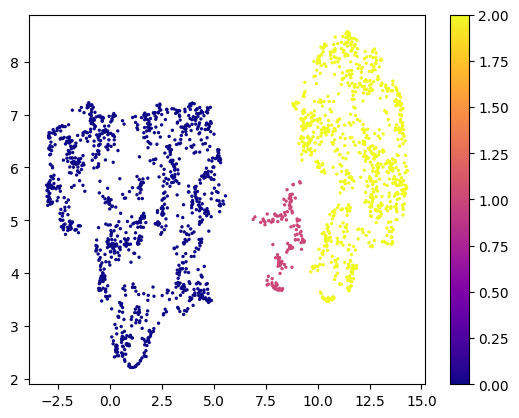

In [24]:
plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=est_hdbscan.labels_, cmap=plt.colormaps['plasma'])
plt.colorbar()

In [ ]:
# Vascular risk factor SHAP

           

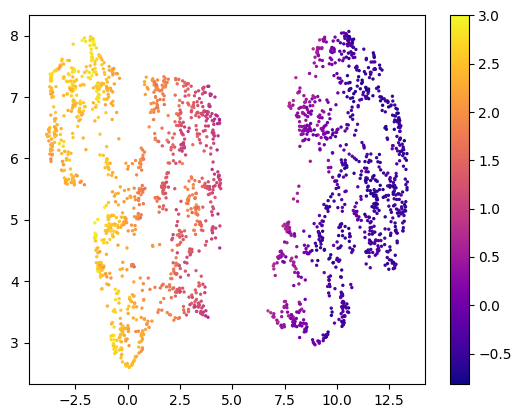

In [175]:
# IOP SHAP

idx = np.where(reconstructed_df.columns == 'IOPcc_mean_tx_adjusted')[0][0]
plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=explanation[glaucoma_idx_true].values[:, idx], cmap=plt.colormaps['plasma'])
plt.colorbar()

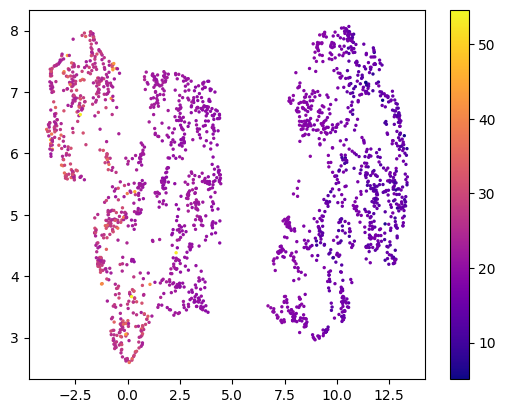

In [176]:
# IOP value

plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=reconstructed_df_with_def_no_scale_glaucoma['IOPcc_mean_tx_adjusted'], cmap=plt.colormaps['plasma'])
plt.colorbar()

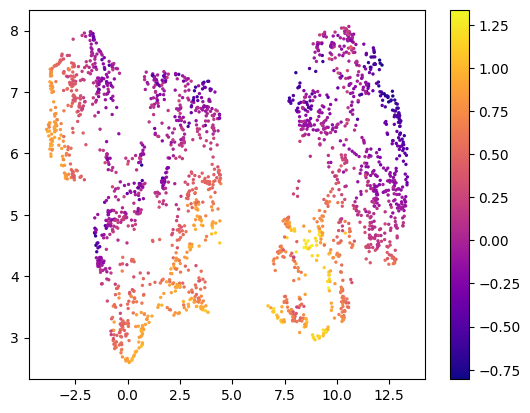

In [177]:
# PRS SHAP

idx = np.where(reconstructed_df.columns == 'Standardized_PRS_Craig2020')[0][0]
plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=explanation[glaucoma_idx_true].values[:, idx], cmap=plt.colormaps['plasma'])
plt.colorbar()

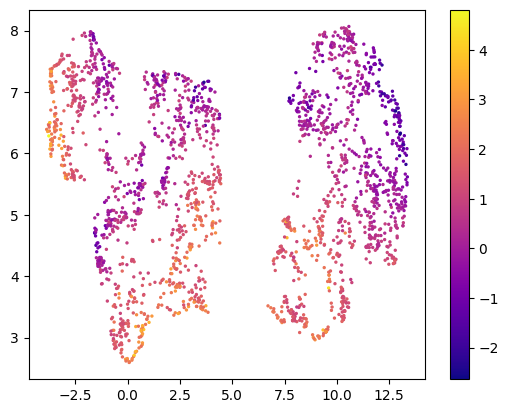

In [178]:
# PRS value

plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=reconstructed_df_with_def_no_scale_glaucoma['Standardized_PRS_Craig2020'], cmap=plt.colormaps['plasma'])
plt.colorbar()

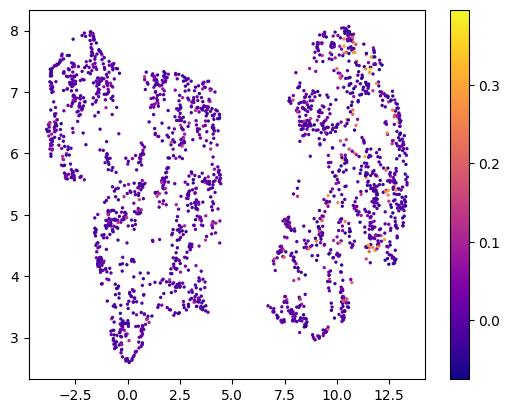

In [203]:
# DBP SHAP

idx = np.where(reconstructed_df.columns == 'HBA1c_mmol')[0][0]
plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=explanation[glaucoma_idx_true].values[:, idx], cmap=plt.colormaps['plasma'])
plt.colorbar()

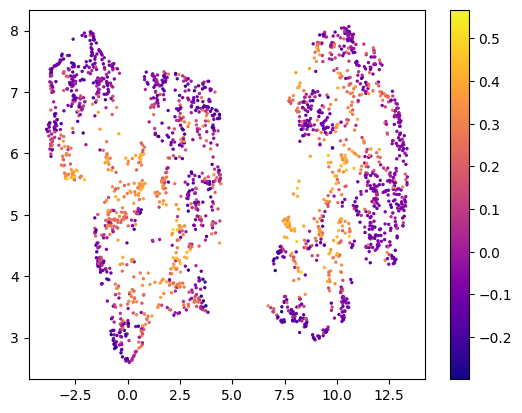

In [164]:
# RNFL SHAP

idx = np.where(reconstructed_df.columns == 'RNFL_thickness_mean')[0][0]
plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=explanation[glaucoma_idx_true].values[:, idx], cmap=plt.colormaps['plasma'])
plt.colorbar()

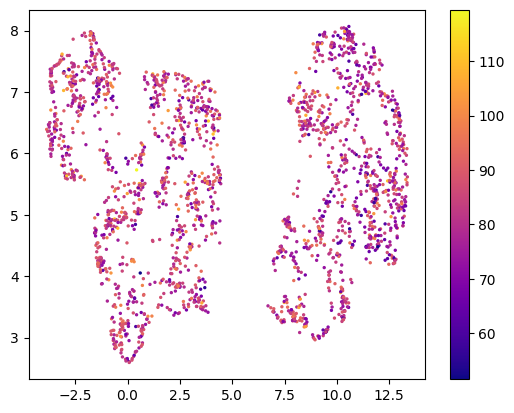

In [199]:
# RNFL value

plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=reconstructed_df_with_def_no_scale_glaucoma['diastolic_BP'], cmap=plt.colormaps['plasma'])
plt.colorbar()

# 2-cluster analysis on glaucoma only - systemic features

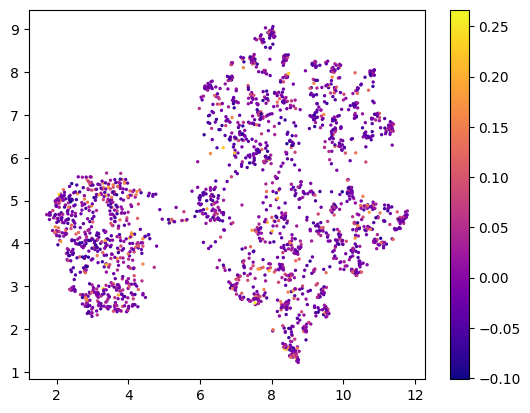

In [480]:
# DBP SHAP

idx = np.where(reconstructed_df.columns == 'diastolic_BP')[0][0]
plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=explanation[glaucoma_idx_true].values[:, idx], cmap=plt.colormaps['plasma'])
plt.colorbar()

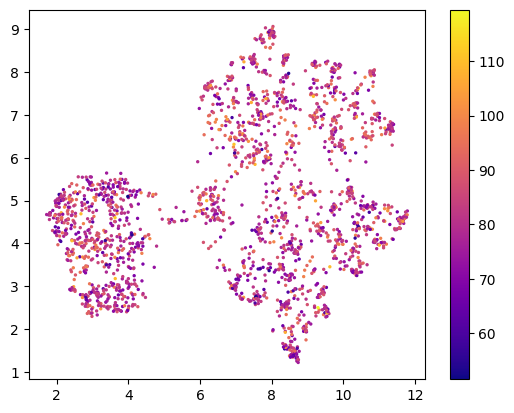

In [481]:
# DBP value

plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=reconstructed_df_with_def_no_scale_glaucoma['diastolic_BP'], cmap=plt.colormaps['plasma'])
plt.colorbar()

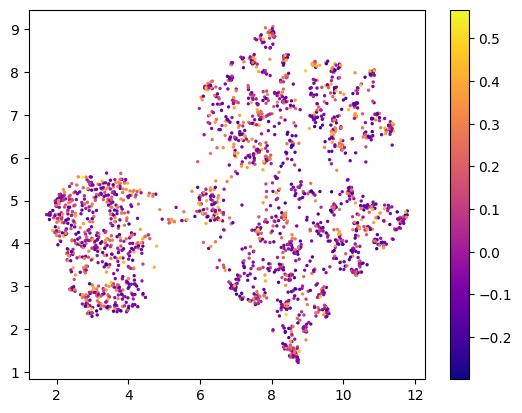

In [482]:
# RNFL SHAP

idx = np.where(reconstructed_df.columns == 'RNFL_thickness_mean')[0][0]
plt.scatter(umapped[:, 0], umapped[:, 1], s=2, c=explanation[glaucoma_idx_true].values[:, idx], cmap=plt.colormaps['plasma'])
plt.colorbar()